In [2]:
!pip install yfinance
!pip install nltk
!pip install vaderSentiment
!pip install requests

import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.2 MB/s eta 0:00:00


In [3]:

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# --- 1. Fetch Netflix Stock Data (Updated Dates) ---
start_date = "2025-05-01"
end_date = "2025-06-01"

netflix = yf.Ticker("NFLX")
stock_data = netflix.history(start=start_date, end=end_date)
stock_data.reset_index(inplace=True)
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# --- 2. Fetch News Articles ---
api_key = "e61bdf623580436a84e7d113bc8fa07b"
url = 'https://newsapi.org/v2/everything'
params = {
    'q': 'Netflix',
    'from': start_date,
    'to': end_date,
    'sortBy': 'relevancy',
    'apiKey': api_key,
    'pageSize': 100,
    'language': 'en'
}

response = requests.get(url, params=params)
data = response.json()

if data['status'] != 'ok':
    raise Exception(f"NewsAPI error: {data['message']}")

articles = data['articles']
news_data = pd.DataFrame(articles)[['publishedAt', 'title']]
news_data.columns = ['date', 'headline']
news_data['date'] = pd.to_datetime(news_data['date']).dt.date

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
stock_data


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-05-01,1122.520020,1142.420044,1111.829956,1133.469971,3499500,0.0,0.0
1,2025-05-02,1136.660034,1159.439941,1133.319946,1156.489990,3774300,0.0,0.0
2,2025-05-05,1114.800049,1144.020020,1107.010010,1134.060059,5662300,0.0,0.0
3,2025-05-06,1129.430054,1147.660034,1126.400024,1137.689941,3256700,0.0,0.0
4,2025-05-07,1139.180054,1164.000000,1138.000000,1155.410034,4349700,0.0,0.0
5,2025-05-08,1161.619995,1162.290039,1139.199951,1144.430054,3760900,0.0,0.0
6,2025-05-09,1147.099976,1151.000000,1133.219971,1140.219971,2569600,0.0,0.0
7,2025-05-12,1124.260010,1130.000000,1102.930054,1110.000000,6479100,0.0,0.0
8,2025-05-13,1114.459961,1147.880005,1106.300049,1138.439941,3997900,0.0,0.0
9,2025-05-14,1129.599976,1152.900024,1128.400024,1150.989990,3910100,0.0,0.0


In [7]:
import nltk
nltk.download('punkt_tab')

# --- 3. Preprocess Headlines ---
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha()]
    words = [word.lower() for word in words if word.lower() not in stop_words]
    return ' '.join(words)

news_data['cleaned_headline'] = news_data['headline'].apply(preprocess_text)

# --- 4. Sentiment Analysis ---
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

news_data['sentiment_score'] = news_data['cleaned_headline'].apply(get_sentiment_score)

# --- 5. Aggregate Sentiment Scores by Date ---
aggregated_sentiment = news_data.groupby('date')['sentiment_score'].mean().reset_index()

# --- 6. Merge with Stock Data ---
combined_data = pd.merge(stock_data, aggregated_sentiment, left_on='Date', right_on='date', how='inner')

# --- 7. Generate Trading Signals ---
def generate_signal(score):
    if score > 0.2:
        return "BUY"
    elif score < -0.2:
        return "SELL"
    else:
        return "HOLD"

combined_data['Signal'] = combined_data['sentiment_score'].apply(generate_signal)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
news_data

,date,headline,cleaned_headline,sentiment_score
0,2025-05-09,Netflix is removing Black Mirror: Bandersnatch,netflix removing black mirror bandersnatch,0.0000
1,2025-05-14,Netflix is bringing back Star Search as a live...,netflix bringing back star search live show,0.0000
2,2025-05-24,The oldest Fire TV devices are losing Netflix ...,oldest fire tv devices losing netflix support ...,-0.3182
3,2025-05-28,Netflix co-founder Reed Hastings joins Anthrop...,netflix reed hastings joins anthropic board di...,0.0000
4,2025-05-07,Netflix’s UI Overhaul Traps You Into Binging F...,netflix ui overhaul traps binging forever,0.0000
...,...,...,...,...
90,2025-05-20,Don’t be surprised Guillermo del Toro says his...,surprised guillermo del toro says frankenstein...,-0.4215
91,2025-05-20,Netflix’s next big video game adaptation is Cl...,netflix next big video game adaptation clash c...,0.0000
92,2025-05-08,Apple Wanted Tim Cook to Appear as Himself in ...,apple wanted tim cook appear comedy show studio,0.3612
93,2025-05-27,Samurai Jack creator Genndy Tartakovsky had to...,samurai jack creator genndy tartakovsky censor...,-0.4588


from matplotlib import pyplot as plt
news_data['sentiment_score'].plot(kind='hist', bins=20, title='sentiment_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['sentiment_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = news_data.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('sentiment_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = news_data.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
news_data['sentiment_score'].plot(kind='line', figsize=(8, 4), title='sentiment_score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['sentiment_score'].plot(kind='hist', bins=20, title='sentiment_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='sentiment_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['sentiment_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('sentiment_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['sentiment_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('sentiment_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['sentiment_score'].plot(kind='line', figsize=(8, 4), title='sentiment_score')
plt.gca().spines[['top', 'right']].set_visible(False)

          Date        Close  sentiment_score Signal
0   2025-05-01  1133.469971         0.062500   HOLD
1   2025-05-02  1156.489990        -0.401900   SELL
2   2025-05-05  1134.060059        -0.015280   HOLD
3   2025-05-06  1137.689941        -0.077200   HOLD
4   2025-05-07  1155.410034         0.233610    BUY
5   2025-05-08  1144.430054        -0.066267   HOLD
6   2025-05-09  1140.219971         0.276300    BUY
7   2025-05-13  1138.439941        -0.024125   HOLD
8   2025-05-14  1150.989990        -0.056475   HOLD
9   2025-05-15  1177.979980         0.196525   HOLD
10  2025-05-16  1191.530029        -0.267150   SELL
11  2025-05-19  1191.640015         0.000000   HOLD
12  2025-05-20  1192.020020         0.027362   HOLD
13  2025-05-21  1194.630005         0.080500   HOLD
14  2025-05-22  1187.969971         0.571900    BUY
15  2025-05-23  1185.390015         0.458525    BUY
16  2025-05-27  1211.569946        -0.229400   SELL
17  2025-05-28  1208.550049         0.000000   HOLD
18  2025-05-

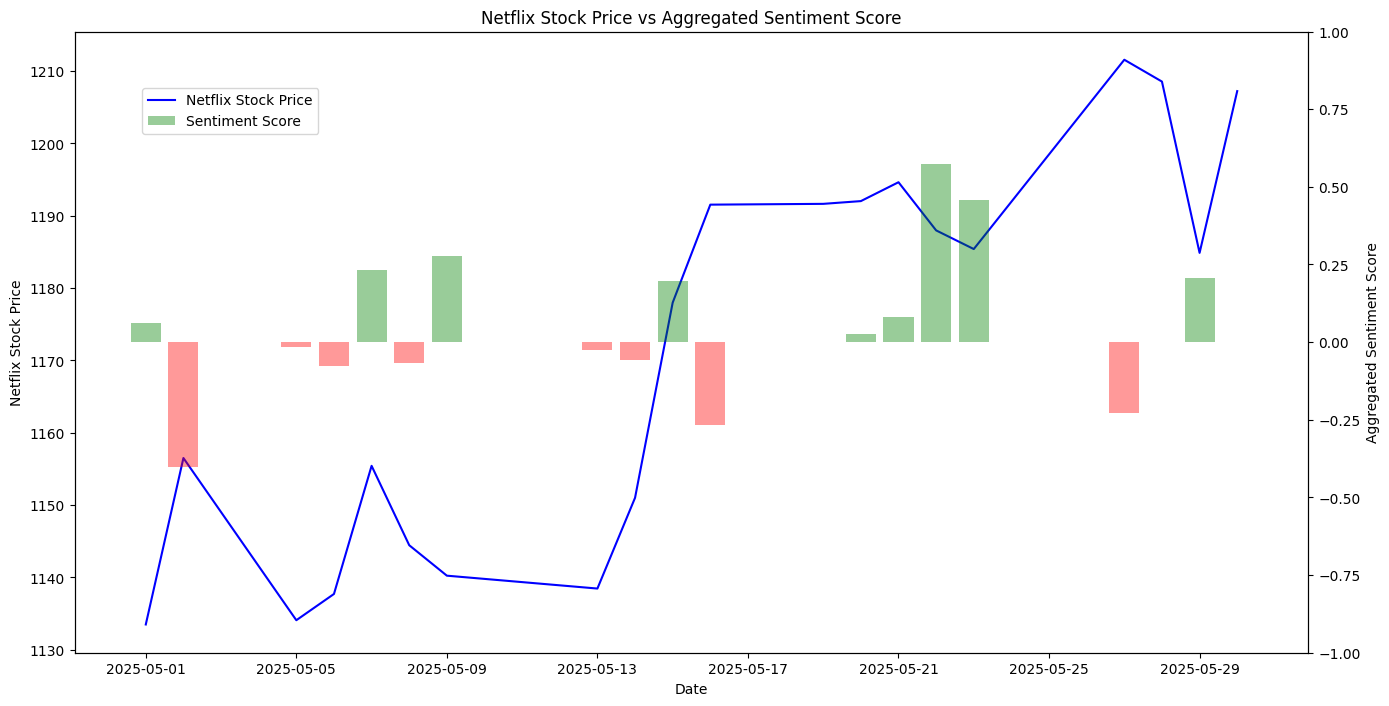

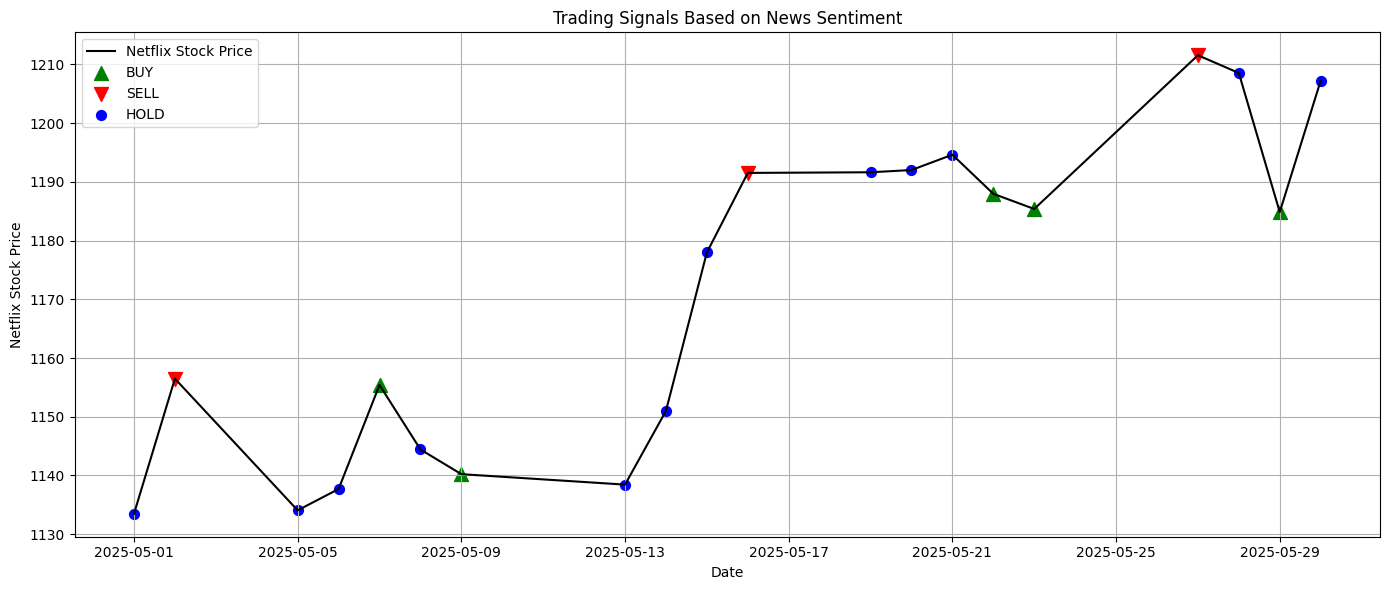

In [8]:
# --- 8. Output Table ---
print(combined_data[['Date', 'Close', 'sentiment_score', 'Signal']])

# --- 9. Visualization 1: Stock Price vs Sentiment Score ---
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.set_xlabel('Date')
ax1.set_ylabel('Netflix Stock Price')
ax1.plot(combined_data['Date'], combined_data['Close'], label='Netflix Stock Price', color='blue')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('Aggregated Sentiment Score')
colors = ['green' if val >= 0 else 'red' for val in combined_data['sentiment_score']]
ax2.bar(combined_data['Date'], combined_data['sentiment_score'], color=colors, alpha=0.4, label='Sentiment Score')
ax2.tick_params(axis='y')
ax2.set_ylim(-1, 1)

fig.tight_layout()
plt.title('Netflix Stock Price vs Aggregated Sentiment Score')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

# --- 10. Visualization 2: Signals on Price Chart ---
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(combined_data['Date'], combined_data['Close'], label='Netflix Stock Price', color='black')

# Markers for BUY, SELL, HOLD
buy_dates = combined_data[combined_data['Signal'] == 'BUY']
sell_dates = combined_data[combined_data['Signal'] == 'SELL']
hold_dates = combined_data[combined_data['Signal'] == 'HOLD']

ax.scatter(buy_dates['Date'], buy_dates['Close'], color='green', label='BUY', marker='^', s=100)
ax.scatter(sell_dates['Date'], sell_dates['Close'], color='red', label='SELL', marker='v', s=100)
ax.scatter(hold_dates['Date'], hold_dates['Close'], color='blue', label='HOLD', marker='o', s=50)

ax.set_xlabel('Date')
ax.set_ylabel('Netflix Stock Price')
plt.title('Trading Signals Based on News Sentiment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
